# Group 3: College ROI (Simple Baseline)

Goal: test which school characteristics are linked to median earnings 10 years after entry.


In [39]:
# import statements
import pandas as pd
from davis_stats import reg, scatter

pd.set_option('display.float_format', '{:,.2f}'.format)
import matplotlib.pyplot as plt


In [40]:
# load data
file_path = "../data/raw/Most-Recent-Cohorts-Institution.csv"

df = pd.read_csv(file_path, low_memory=False)
print(df.shape)


(6429, 3306)


In [41]:
# variable labels
var_labels = {
    'stem_share': 'STEM Enrollment Share',
    'MEDIAN_HH_INC': 'Median Household Income',
    'PCTPELL': 'Percent Pell Grant Recipients',
    'completion_rate': 'Completion Rate',
    'Intercept': 'Constant'
}

In [42]:
# columns to keep
cols = [
    "INSTNM", "STABBR", "CONTROL", "REGION", "LOCALE",
    "MD_EARN_WNE_P10", "MEDIAN_HH_INC", "PCTPELL",
    "C150_4", "C150_L4",
    "PCIP11", "PCIP14", "PCIP15", "PCIP26", "PCIP27", "PCIP40", "PCIP41"
]

df = df[cols].copy()

# make numeric columns numeric
num_cols = [
    "MD_EARN_WNE_P10", "MEDIAN_HH_INC", "PCTPELL", "C150_4", "C150_L4",
    "PCIP11", "PCIP14", "PCIP15", "PCIP26", "PCIP27", "PCIP40", "PCIP41"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [56]:
# build features
stem_cols = ["PCIP11", "PCIP14", "PCIP15", "PCIP26", "PCIP27", "PCIP40", "PCIP41"]
df["stem_share"] = df[stem_cols].fillna(0).sum(axis=1)
df["completion_rate"] = df["C150_4"].fillna(df["C150_L4"])

# rows for modeling
model_df = df.dropna(subset=[
    "MD_EARN_WNE_P10", "MEDIAN_HH_INC", "PCTPELL",
    "stem_share", "completion_rate", "CONTROL", "REGION", "LOCALE"
]).copy()

print(f'Modeling sample size: {model_df.shape[0]} institutions')

summary = model_df[['MD_EARN_WNE_P10', 'stem_share', 'MEDIAN_HH_INC', 'PCTPELL']]
summary = summary.rename(columns={
    'MD_EARN_WNE_P10': 'Median Earnings (10 Years After Entry)',
    'stem_share': 'STEM Enrollment Share',
    'MEDIAN_HH_INC': 'Median Household Income',
    'PCTPELL': '% of Students Receiving Pell Grants'
})

summary.describe()


Modeling sample size: 4212 institutions


,Median Earnings (10 Years After Entry),STEM Enrollment Share,Median Household Income,% of Students Receiving Pell Grants
count,"4,212.00","4,212.00","4,212.00","4,212.00"
mean,"43,588.03",0.10,"58,026.25",0.42
std,"16,284.92",0.13,"12,885.85",0.20
min,"9,656.00",0.00,"15,790.53",0.00
25%,"32,568.00",0.00,"49,701.65",0.26
50%,"41,000.00",0.06,"57,419.93",0.38
75%,"52,164.75",0.15,"66,211.08",0.55
max,"143,372.00",1.00,"100,870.75",1.00


## Baseline Model
Earnings on income controls + location.


In [66]:
baseline = reg(
    model_df,
    'MD_EARN_WNE_P10',
    ['MEDIAN_HH_INC', 'PCTPELL'],
    dummies=['REGION', 'LOCALE'],
    silent=True
)

print('\nBaseline Model: Student Background and Location Controls')
print(baseline.summary())

coef = baseline.params[['MEDIAN_HH_INC', 'PCTPELL']].rename(var_labels)
print('\nKey Baseline Coefficients ($):')
print(coef.round(2))


Baseline Model: Student Background and Location Controls
                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     135.3
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:40:52   Log-Likelihood:                -45654.
No. Observations:                4212   AIC:                         9.136e+04
Df Residuals:                    4188   BIC:                         9.151e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

## Full Model
Adds STEM share, school type, and completion.


In [45]:
full = reg(
    model_df,
    'MD_EARN_WNE_P10',
    ['stem_share','MEDIAN_HH_INC', 'PCTPELL', 'completion_rate'],
    dummies=['CONTROL', 'REGION', 'LOCALE'],
    silent=True
)

print(full.summary())

                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     234.9
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        11:16:00   Log-Likelihood:                -44881.
No. Observations:                4212   AIC:                         8.982e+04
Df Residuals:                    4184   BIC:                         9.000e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.327e+04   1.48e+04     

In [46]:
# compare models
print('Baseline R^2:', round(baseline.rsquared, 4))
print('Full R^2:', round(full.rsquared, 4))

coef = full.params[['stem_share', 'completion_rate', 'MEDIAN_HH_INC', 'PCTPELL']]
coef = coef.rename(var_labels)

print('\nKey Full-Model Coefficients ($):')
print(coef.round(2))


Baseline R^2: 0.4264
Full R^2: 0.6025

Key Full-Model Coefficients ($):
STEM Enrollment Share           34,484.53
Completion Rate                  9,046.31
Median Household Income              0.38
Percent Pell Grant Recipients   -9,928.23
dtype: float64


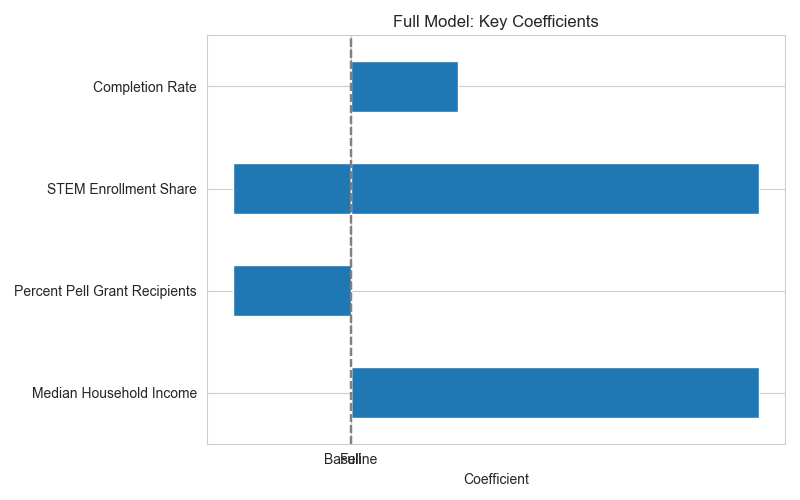

In [47]:
# coefficient plot
plt.axvline(0, color='gray', linestyle='--')
plt.title('Full Model: Key Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('')
plt.tight_layout()
plt.show()


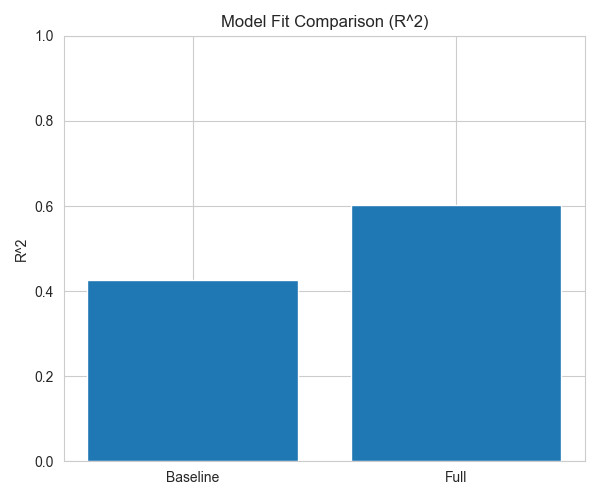

In [48]:
# R^2 chart
labels = ['Baseline', 'Full']
values = [baseline.rsquared, full.rsquared]
plt.figure(figsize=(6, 5))
plt.bar(labels, values)
plt.ylim(0, 1)
plt.title('Model Fit Comparison (R^2)')
plt.ylabel('R^2')
plt.tight_layout()
plt.show()


In [ ]:
# stem-only r2
stem_only = reg(
    model_df,
    'MD_EARN_WNE_P10',
    ['stem_share', 'MEDIAN_HH_INC', 'PCTPELL'],
    dummies=['REGION', 'LOCALE'],
    silent=True
)

print('Stem-only R^2:', round(stem_only.rsquared, 4))

Stem-only R^2: 0.5291


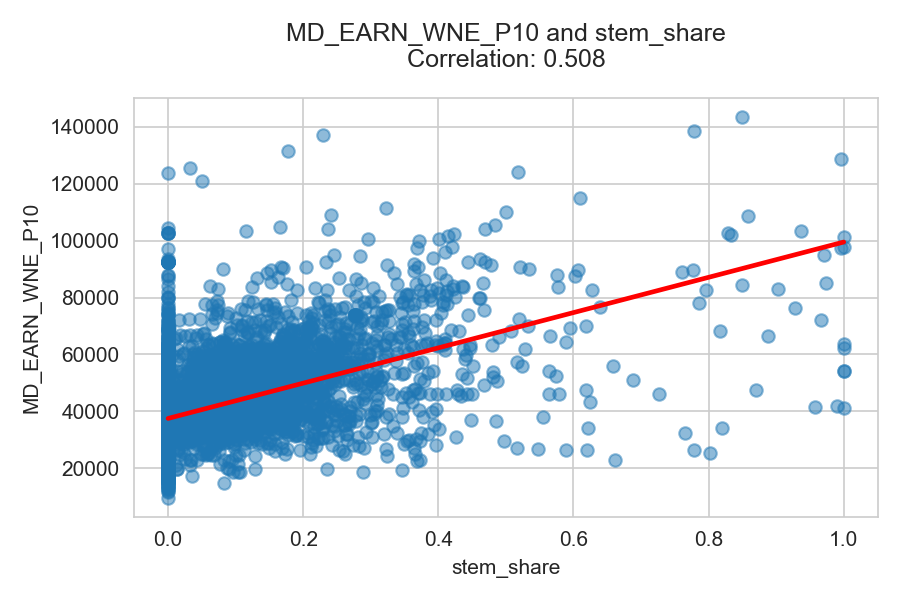

In [49]:
# scatter plot
scatter(model_df, 'MD_EARN_WNE_P10', 'stem_share', fit_line=True)


In [50]:
model_df[['MD_EARN_WNE_P10', 'stem_share', 'completion_rate',
          'MEDIAN_HH_INC', 'PCTPELL']].corr()

,MD_EARN_WNE_P10,stem_share,completion_rate,MEDIAN_HH_INC,PCTPELL
MD_EARN_WNE_P10,1.00,0.51,0.18,0.53,-0.50
stem_share,0.51,1.00,0.07,0.20,-0.29
completion_rate,0.18,0.07,1.00,0.22,-0.02
MEDIAN_HH_INC,0.53,0.20,0.22,1.00,-0.38
PCTPELL,-0.50,-0.29,-0.02,-0.38,1.00


In [58]:
print('\nSelected Full-Model Effects:')
print(full.params[['stem_share', 'completion_rate']].round(2))


Selected Full-Model Effects:
stem_share        34,484.53
completion_rate    9,046.31
dtype: float64


In [61]:
# stem x completion interaction
model_df['stem_x_completion'] = (
    model_df['stem_share'] * model_df['completion_rate']
)

interaction_model = reg(
    model_df,
    'MD_EARN_WNE_P10',
    ['stem_share', 'completion_rate', 'stem_x_completion',
     'MEDIAN_HH_INC', 'PCTPELL'],
    dummies=['CONTROL', 'REGION', 'LOCALE'],
    silent=True
)

print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     252.4
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:34:54   Log-Likelihood:                -44740.
No. Observations:                4212   AIC:                         8.954e+04
Df Residuals:                    4183   BIC:                         8.972e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.274e+04   1.43e+0